<a href="https://colab.research.google.com/github/aslinura/Airbnb_NYC_Price_Prediction/blob/main/Airbnb_3_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BrainStation Capstone Project**   

---



### **Airbnb Price Prediction in NYC** 

Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 3 of 5


#### **RECAP**

In the previous notebook, we have

- Splitted the samples into training-test datasets

- Completed text analysis: BOW & TFIDF techniques were used to extract the significant tokens from the amenities, name, and description columns

- Encoded the non numerical values

- Optimized the skew in some independent variables

- Resolved the multicollinearity issue which was occured again as a result of encoding the categorical columns

- Saved the following dataframes as a csv file:

      X_train | X_test

      y_train | y_test

###▶ **NOTEBOOK 3: MODELLING | LINEAR MODELS**


---

The purpose is to fit the datasets to various Linear Models and optimize the models with lowest computation cost and highest R^2. Finally we aim to achieve the lowest Mean Absolute Error score and highest R^2 score by ensuring that the final model does not overfit.

**Modelling | Linear Models Steps:**


1.    Build Baseline Linear Regression Models of OSL, Ridge, Lasso, and ElasticNetCV:


2.    OSL Regression Model with scaled data:
      *   Linear Regression Model with the scaled data including newly engineered text analysis features


3.  SVM 

4.  Linear Regression Model with Lasso Regularization:
      *   Lasso Regression Model with the scaled data including newly engineered text analysis features

 Optimize the model with GridSearch + cross validation
      *   Optimized Lasso Regression Model with the scaled data
      *   Optimized Lasso Regression Model with the scaled and dimensionally reduced dataset
      *   Model Evaluation aka Feature Coefficient Interpretation


5. Model Comparison Table

####**Highlights of this Notebook:**


*   Optimized Lasso Regresion had the highest score (59% variance (R^2 score) and 47 US dollar MAE value).

*   StandardScaler, MinMaxScaler, and Robust Scaler were added in the GridSearch; however the optimal hyperparameter group included neither a scaler nor normalizer and scales the data to the unit variance.


*   If the property is an entire house or located in Manhattan or in Brooklyn neighborhoods which are closer to Manhattan are more likely to be priced higher. They have the highest influence on the price.



*   Number of accommodates and bathrooms or offering a king size bed or washer in the unit or the building impact the prices in a positive way.
*   Surprisingly hosts who never responds or respond less 25% of the received messages tend to list their properties at higher price. We believe that they might have not done a propery marketing research before listing their property and do allocate enough time on their Airbnb business. Their occupancy rate may be helpful to answer these questions.
*  If the property is located above 59th street in Manhattan or in Staten Island or in Bronx, it is more likely to be listed at a lower price.
*   Minimum required night is has one of the highly influencial factor on pricing. As it is increasing, the price tends to be lower.
*   Full size is another disadvantage for the hosts.





*   Surprisingly as number of reviews increase, the price tends to decrease based on the lasso model.








Installing required packages:

In [ ]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']


# View the entire output in a table
#%load_ext google.colab.data_table

# Shrink the cell output
#from IPython import display
#display.Javascript("google.colab.output.setIframeHeight('200px');")

#from google.colab import data_table
#data_table.disable_dataframe_formatter()

import pandas as pd
import gzip
import shutil

# Import required libraries

import gzip
import shutil

import numpy as np
import pandas as pd


# Plotting
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix



# Scalers & PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,RepeatedKFold,StratifiedKFold, RandomizedSearchCV



# Model Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,median_absolute_error,mean_absolute_percentage_error
from scipy import stats


# Building models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,ElasticNetCV,BayesianRidge
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score



# Pipeline 
from tempfile import mkdtemp
cachedir = mkdtemp()
from sklearn.pipeline import Pipeline


# Seed number
seed=42




Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Create a seaborn countplot function, which counts the observations in each categorical bin using bar.
def perc_graph (variable, dataset, title):
    sns.set_style("white")    #have a white background
      # set plot dimensions
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(x=variable, data=dataset, palette="Set2") #define the x and y axis and decide the color set
    plt.title(title)
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    
    for i in axis.patches:   #create patches to calculate the percentage of each column
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn scatterplot graph function with hue=price to examine the distribution of disease presence in the selected variables
def scatter(dataset, variable_x, variable_y):
    sns.set_style("white")
    sns.scatterplot(x=dataset[variable_x],y=dataset[variable_y],hue=dataset['price'],palette="Set3")


#Create a seaborn countplot function with hue=WMNV to examine the disease presense distribution in the selected variable
def hue_graph(variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(8,8))
    Y= dataset[variable]
    total=len(Y)
    axis=sns.countplot(x=variable, data=dataset, hue="price", palette="Set3", order = dataset[variable].value_counts().index)
    plt.title(title, fontsize=15)
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    for i in axis.patches:
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn horizantal bar graph
def barh_graph (variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(15,5))  #graph size
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(y=variable, data=dataset, palette="Set3", order = dataset[variable].value_counts().index) #defining the axis x and y  #sns refers to the statistical graph
    plt.title(title, fontsize=15)
    plt.xlabel('Number of Instances')
    plt.ylabel(variable, size=12)
    plt.show()

    
#Create a kernel density estimate (KDE) seaborn plot to illustrate the distribution of all the mosquitoes caught in a single trap.
def kde(variable, dataset, title):
    sns.set(rc={"figure.figsize":(9, 6)})
    sns.kdeplot(data=dataset, x=variable, shade=True, color="r").set(title=title, xlabel=variable)
    
    
#Create a seaborn line plot to display the evaluation of one numerical variable over time so variable_x is going to be labeled with numerical columns including time values. 
def line(variable_x, variable_y, dataset, title):
    sns.set(rc={"figure.figsize":(8, 8)})
    sns.lineplot(x = variable_x, y = variable_y, data = dataset).set(title=title, ylabel=variable_y, xlabel=variable_x,)
    plt.xticks(rotation = 25)   #rotate the x axis values
    

def plot_coefficients(x,dataset,model_type):   
    
    plt.figure(figsize=(20,8))
    #Plot Searborn bar chart
    ax=dataset['coefficient'].head(40).plot(kind='bar', x=x,
                    color=(dataset['coefficient'] > 0).map({True: 'g',
                                                    False: 'r'}))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.title( model_type + ' FEATURE COEFFICIENTS')
    plt.ylabel('FEATURE COEFFICIENTS')
    plt.xlabel('FEATURE NAMES')

In [ ]:
# Please ensure that Brainstation Capstone Folder is uploaded to your drive
from google.colab import drive

drive.mount('/content/drive')

!ls "/content/drive/My Drive/Brainstation Capstone"

Mounted at /content/drive
 Aslinur_Acarlioglu_Capstone_Report.pdf   File_List_Aslinur_Acarlioglu.md
'Colab Notebooks'			  june_listings.csv.gz
 df_listing.csv				  X_data
 df_preprocessed_capped.csv		  y_data


In [ ]:
# Pull the preprocessed dataset
X_train=pd.read_csv('drive/My Drive/X_train.csv')
X_validation=pd.read_csv('drive/My Drive/X_validation.csv')
X_test=pd.read_csv('drive/My Drive/X_test.csv')




y_train=pd.read_csv('drive/My Drive/y_train.csv')

y_test=pd.read_csv('drive/My Drive/y_test.csv')

print(f'Recall the shape of the the preprocessed dataset: {X_train.shape}')

print(f'Recall the shape of the the preprocessed dataset: {X_test.shape}')
print('--------------')
print(f'Recall the shape of the the preprocessed dataset: {y_train.shape}')

print(f'Recall the shape of the the preprocessed dataset: {y_test.shape}')

Recall the shape of the the preprocessed dataset: (25107, 64)
Recall the shape of the the preprocessed dataset: (6277, 64)
--------------
Recall the shape of the the preprocessed dataset: (25107, 1)
Recall the shape of the the preprocessed dataset: (6277, 1)


In [ ]:
# Take the log of all dependent variables
y_log_train= np.log1p(y_train)
y_log_test= np.log1p(y_test)


### **Principal Component Analysis (PCA):**



---



PCA technique is primarily used to reduce the computation cost by reducing the dimensionality in the dataset; however it helps to address the multicollinearity issue too. We will also use this technique toward the end of the notebook.

In [ ]:
from tqdm import tqdm
lista = range(1,(len(X_train.columns)+1))   # select the number of the columns
aa=[]
bb=[]
for f in tqdm(lista):
    aa.append(f)
    pca = PCA(n_components=f).fit(X_train)  # Fit the train dataset
    
a = 0
for e in lista:
    a=a+pca.explained_variance_ratio_[e-1]    
    bb.append(a)

100%|██████████| 64/64 [00:16<00:00,  3.94it/s]


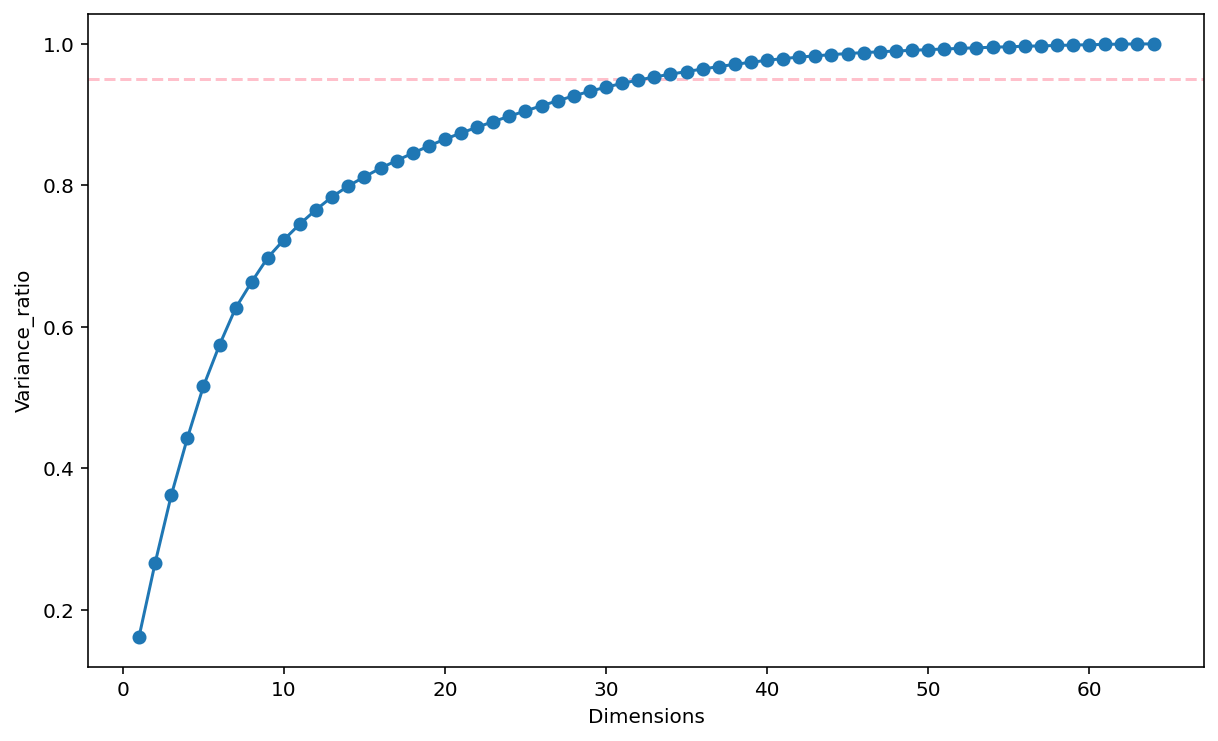

In [ ]:
# Plot PCA variance ratio
fig, ax = plt.subplots(figsize = (10,6))
plt.axhline(.95, linestyle='--', color='pink', label='95% cum. sum')
plot = plt.plot(aa, bb, '-o')
ax.set_xlabel("Dimensions")
ax.set_ylabel("Variance_ratio"); 

Only 32 features seem to be enough to explain 95% of the variance in the data.

In [ ]:
# Find the number of dimensions at 95% ratio
pca = PCA(n_components=32).fit(X_train)
print(sum(pca.explained_variance_ratio_)) 


0.9488956094356737


In [ ]:
# Apply PCA for dimension reduction but we will use them later
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Again, we will use these dimensionally reduced datasets later. 

# MODELLING
---


**Baseline Models (without the log version of target variable):**

In [ ]:
regressor = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNetCV Regression']
models = [LinearRegression(), Ridge(), Lasso(),ElasticNetCV()]

train_r_squared = []
train_MAE = []

test_r_squared = []
test_MAE = []


for m in models:

    linear_optimized=m.fit(X_train, y_train)
    y_pred=linear_optimized.predict(X_test)
    y_train_pred=linear_optimized.predict(X_train)


    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r_squared.append(train_r2)
    train_MAE.append(train_mae)


    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r_squared.append(test_r2)
    test_MAE.append(test_mae)




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
basic_result_no_log = pd.DataFrame({'Train R squared':train_r_squared,'Test R squared':test_r_squared,'Train MAE':train_mae,'Test MAE':test_mae}, index=regressor)
round(basic_result_no_log,2)


,Train R squared,Test R squared,Train MAE,Test MAE
Linear Regression,0.60,0.59,50.98,50.61
Ridge Regression,0.60,0.59,50.98,50.61
Lasso Regression,0.58,0.57,50.98,50.61
ElasticNetCV Regression,0.58,0.57,50.98,50.61


Linear and Ridge Regression are performing better than Lasso and ElasticNetCV by 1%. Let's try to rescale the data and use the log version of y:

In [ ]:
regressor = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNetCV Regression']
models = [LinearRegression(), Ridge(), Lasso(alpha=0.001),ElasticNetCV()]

train_r_squared = []
train_MAE = []

test_r_squared = []
test_MAE = []


for m in models:
        # Cross validation with RepeatedKFold
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 

    # Scaler
    scaler = StandardScaler() 

    # Build pipeline
    estimators=[('scaler', scaler),('estimator',m)]  #('PolyFeatures',PolynomialFeatures(2)) takes too long 
    linear_pipe = Pipeline(estimators)   


    #mean_val_scores = cross_val_score(linear_pipe, X_train, y_log_train, cv = cv, scoring='r2')  # metric score=mean absolute error

    linear_optimized=linear_pipe.fit(X_train, y_log_train)
    y_pred=linear_optimized.predict(X_test)
    y_train_pred=linear_optimized.predict(X_train)


    # Inverse log transformation
    y_train_rev=np.expm1(y_log_train)
    y_train_pred_rev=np.expm1(y_train_pred)

    y_test_rev=np.expm1(y_log_test)
    y_pred_rev=np.expm1(y_pred)


    train_r2 = r2_score(y_train_rev, y_train_pred_rev)
    train_mae = mean_absolute_error(y_train_rev, y_train_pred_rev)
    train_r_squared.append(train_r2)
    train_MAE.append(train_mae)


    test_r2 = r2_score(y_test_rev, y_pred_rev)
    test_mae = mean_absolute_error(y_test_rev, y_pred_rev)
    test_r_squared.append(test_r2)
    test_MAE.append(test_mae)





/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
    basic_result_log = pd.DataFrame({'Train R squared':train_r_squared,'Test R squared':test_r_squared,'Train MAE':train_mae,'Test MAE':test_mae}, index=regressor)
    round(basic_result_log,3)

,Train R squared,Test R squared,Train MAE,Test MAE
Linear Regression,0.6,0.6,44.45,44.33
Ridge Regression,0.6,0.6,44.45,44.33
Lasso Regression,0.6,0.6,44.45,44.33
ElasticNetCV Regression,0.6,0.6,44.45,44.33


Great! Although our r^2 scores are low, they are not overfitting.

Let's plot the test score differences when we take the log version of the target variable:

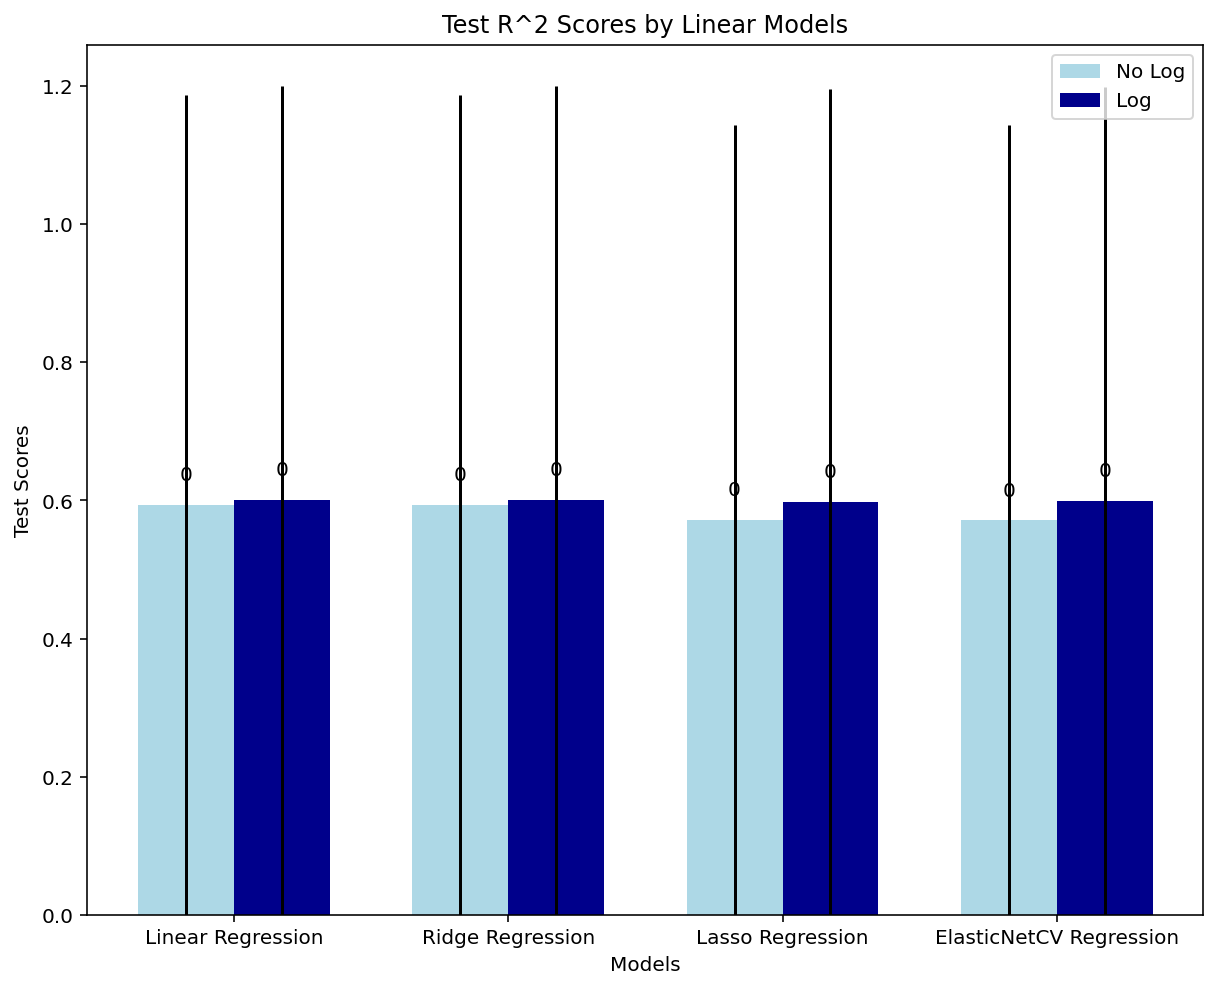

In [ ]:
width = 0.35  
plt.figure(figsize=(10,8))
rects1 = plt.bar(basic_result_no_log.index, basic_result_no_log['Test R squared'], -width, align='edge',
                yerr=basic_result_no_log['Test R squared'], color='lightblue', label='No Log')


rects2 = plt.bar(basic_result_log.index, basic_result_log['Test R squared'], +width, align='edge',
                yerr=basic_result_log['Test R squared'], color='darkblue', label='Log')

# add some text for labels, title and axes ticks
plt.xlabel('Models')
plt.ylabel('Test Scores')
#plt.yscale('log')
plt.title('Test R^2 Scores by Linear Models')
plt.legend()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

After transforming the target variable, all model r^2 scores went up to 60% and error went down by $6. The Ridge and Linear are not overfitting. In this case we will prioritize Linear and Ridge that have the lowest computational cost:

***Hyperparameter Tunning*** 

GridSearch helps us to determine the optimal hyperparameter group. In the search we are using our validation dataset because test data should be unseen.The hyperparameter of Rdige is alpha. A pipeline is built to ensure that the data is standardized before fitted to the model. 

In [ ]:
# Create placeholders for all three steps
estimators = [
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
]

linear_pipe = Pipeline(estimators)

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 
params = [
    {
        'scaler': [StandardScaler(),MinMaxScaler(),RobustScaler(), None],
        'model': [LinearRegression()]
    }, 

  {
        'scaler': [StandardScaler(),MinMaxScaler(),RobustScaler(), None],
        'model': [Ridge()], 
        'model__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
    }, 
 {
        'scaler': [StandardScaler(),MinMaxScaler(),RobustScaler(), None],
        'model': [Lasso(max_iter=100000)], 
        'model__alpha': [1e-7,1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }, 
    {
        'scaler': [StandardScaler(),MinMaxScaler(),RobustScaler(), None],
        'model': [ElasticNetCV()], 
        'model__l1_ratio': [1, 0.01,0.5,0.25,0.75]
    }
]


grid = GridSearchCV(estimator=linear_pipe, cv=cv,
                   param_grid=params, 
                   scoring='neg_mean_absolute_error',verbose=10)

fittedgrid = grid.fit(X_train, y_log_train.values.ravel())

Fitting 30 folds for each of 84 candidates, totalling 2520 fits
[CV 1/30; 1/84] START model=LinearRegression(), scaler=StandardScaler().........
[CV 1/30; 1/84] END model=LinearRegression(), scaler=StandardScaler();, score=-0.278 total time=   0.1s
[CV 2/30; 1/84] START model=LinearRegression(), scaler=StandardScaler().........
[CV 2/30; 1/84] END model=LinearRegression(), scaler=StandardScaler();, score=-0.283 total time=   0.1s
[CV 3/30; 1/84] START model=LinearRegression(), scaler=StandardScaler().........
[CV 3/30; 1/84] END model=LinearRegression(), scaler=StandardScaler();, score=-0.281 total time=   0.1s
[CV 4/30; 1/84] START model=LinearRegression(), scaler=StandardScaler().........
[CV 4/30; 1/84] END model=LinearRegression(), scaler=StandardScaler();, score=-0.275 total time=   0.1s
[CV 5/30; 1/84] START model=LinearRegression(), scaler=StandardScaler().........
[CV 5/30; 1/84] END model=LinearRegression(), scaler=StandardScaler();, score=-0.274 total time=   0.1s
[CV 6/30; 1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.873e+00, tolerance: 8.939e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.283 total time=   2.3s
[CV 3/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 3/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.281 total time=   1.6s
[CV 4/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 4/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.275 total time=   1.5s
[CV 5/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 5/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.274 total time=   1.7s
[CV 6/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 6/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.278 total time=   1.5s
[CV 7/30; 65/84] START model=ElasticNetCV(), mod

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.472e+00, tolerance: 8.941e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 16/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.275 total time=   2.3s
[CV 17/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 17/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.285 total time=   1.7s
[CV 18/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 18/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.286 total time=   1.5s
[CV 19/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 19/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.280 total time=   1.5s
[CV 20/30; 65/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler()
[CV 20/30; 65/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=StandardScaler();, score=-0.279 total time=   1.6s
[CV 21/30; 65/84] START model=ElasticNe

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.476e+00, tolerance: 8.939e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.282 total time=   2.2s
[CV 3/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 3/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.281 total time=   1.5s
[CV 4/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 4/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.275 total time=   1.5s
[CV 5/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 5/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.274 total time=   1.8s
[CV 6/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 6/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.278 total time=   1.6s
[CV 7/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, sc

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e+00, tolerance: 8.941e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 16/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.275 total time=   2.2s
[CV 17/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 17/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.285 total time=   1.9s
[CV 18/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 18/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.286 total time=   1.8s
[CV 19/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 19/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.280 total time=   1.4s
[CV 20/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 20/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.279 total time=   1.9s
[CV 21/30; 66/84] START model=ElasticNetCV(), model__l1_r

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.403e+00, tolerance: 8.968e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 25/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.282 total time=   2.2s
[CV 26/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 26/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.274 total time=   1.8s
[CV 27/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 27/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.278 total time=   2.0s
[CV 28/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 28/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.284 total time=   1.7s
[CV 29/30; 66/84] START model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler()
[CV 29/30; 66/84] END model=ElasticNetCV(), model__l1_ratio=1, scaler=MinMaxScaler();, score=-0.285 total time=   1.9s
[CV 30/30; 66/84] START model=ElasticNetCV(), model__l1_r

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+00, tolerance: 8.939e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.283 total time=   2.2s
[CV 3/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 3/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.281 total time=   1.7s
[CV 4/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 4/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.275 total time=   1.5s
[CV 5/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 5/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.274 total time=   1.4s
[CV 6/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 6/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.278 total time=   1.5s
[CV 7/30; 73/84] START model=E

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e+00, tolerance: 8.941e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 16/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.275 total time=   2.3s
[CV 17/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 17/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.285 total time=   1.5s
[CV 18/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 18/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.286 total time=   1.4s
[CV 19/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 19/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.280 total time=   1.5s
[CV 20/30; 73/84] START model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler()
[CV 20/30; 73/84] END model=ElasticNetCV(), model__l1_ratio=0.5, scaler=StandardScaler();, score=-0.279 total time=   1.5s
[CV 21/30; 73/84] STA

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.349e+00, tolerance: 8.939e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 2/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.283 total time=   2.3s
[CV 3/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 3/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.281 total time=   1.6s
[CV 4/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 4/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.275 total time=   1.5s
[CV 5/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 5/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.274 total time=   1.6s
[CV 6/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 6/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.278 total time=   1.5s
[CV 7/30; 81/84] STAR

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.161e+00, tolerance: 8.941e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 16/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.275 total time=   2.3s
[CV 17/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 17/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.285 total time=   1.5s
[CV 18/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 18/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.286 total time=   1.5s
[CV 19/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 19/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.280 total time=   1.4s
[CV 20/30; 81/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler()
[CV 20/30; 81/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=StandardScaler();, score=-0.279 total time=   1.5s
[CV 21/30; 8

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.105e-01, tolerance: 8.925e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV 27/30; 82/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=MinMaxScaler();, score=-0.278 total time=   2.3s
[CV 28/30; 82/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=MinMaxScaler()
[CV 28/30; 82/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=MinMaxScaler();, score=-0.284 total time=   2.2s
[CV 29/30; 82/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=MinMaxScaler()
[CV 29/30; 82/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=MinMaxScaler();, score=-0.285 total time=   2.2s
[CV 30/30; 82/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=MinMaxScaler()
[CV 30/30; 82/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=MinMaxScaler();, score=-0.280 total time=   2.3s
[CV 1/30; 83/84] START model=ElasticNetCV(), model__l1_ratio=0.75, scaler=RobustScaler()
[CV 1/30; 83/84] END model=ElasticNetCV(), model__l1_ratio=0.75, scaler=RobustScaler();, score=-0.278 total time=   2.5s
[CV 2/30; 83/84] START model=Ela

In [ ]:
#checking the best score and parameter
print("Best parameters:", fittedgrid.best_params_)
print("Lowest NMAE: ", (fittedgrid.best_score_))

Best parameters: {'model': Ridge(), 'model__alpha': 1.0, 'scaler': StandardScaler()}
Lowest NMAE:  -0.27962593801669794


In [ ]:


y_train_pred = fittedgrid.predict(X_train)
y_pred = fittedgrid.predict(X_test)

# Inverse the log transformation
y_train_rev=np.expm1(y_log_train)
y_train_pred_rev=np.expm1(y_train_pred)

y_test_rev=np.expm1(y_log_test)
y_pred_rev=np.expm1(y_pred)





# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train_rev,y_train_pred_rev),2)
test_mean=round(mean_absolute_error(y_test_rev, y_pred_rev),2)

# Define r2 
train_r=r2_score(y_train_rev,y_train_pred_rev)
test_r=r2_score(y_test_rev,y_pred_rev)

n_train=len(X_train)
p_train=len(X_train.columns)

n_test=len(X_test)
p_test=len(X_test.columns)

Adj_train_r2 = 1-(1-train_r)*(n_train-1)/(n_train-p_train) 
Adj_test_r2 = 1-(1-test_r)*(n_test-1)/(n_test-p_test) 


train_r2=round(Adj_train_r2 ,2)
test_r2=round(Adj_test_r2,2)




#print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')


-------------------
Train set Mean AE: 44.43
Test set Mean AE: 44.3
-------------------
Train set r2 score: 0.6
Test set r2 score: 0.6


Hyperparameter tuning including scaling did not improve the result so we do not need to scale the data and can use the default alpha value in Ridge Regression.

Let's refit the train dataset to the ridge regression model:

In [ ]:
# Create an alpha - test result table:
alpha_df=pd.DataFrame(fittedgrid.cv_results_)[['param_model__alpha','mean_test_score']]

In [ ]:
alpha_df

NameError: ignored

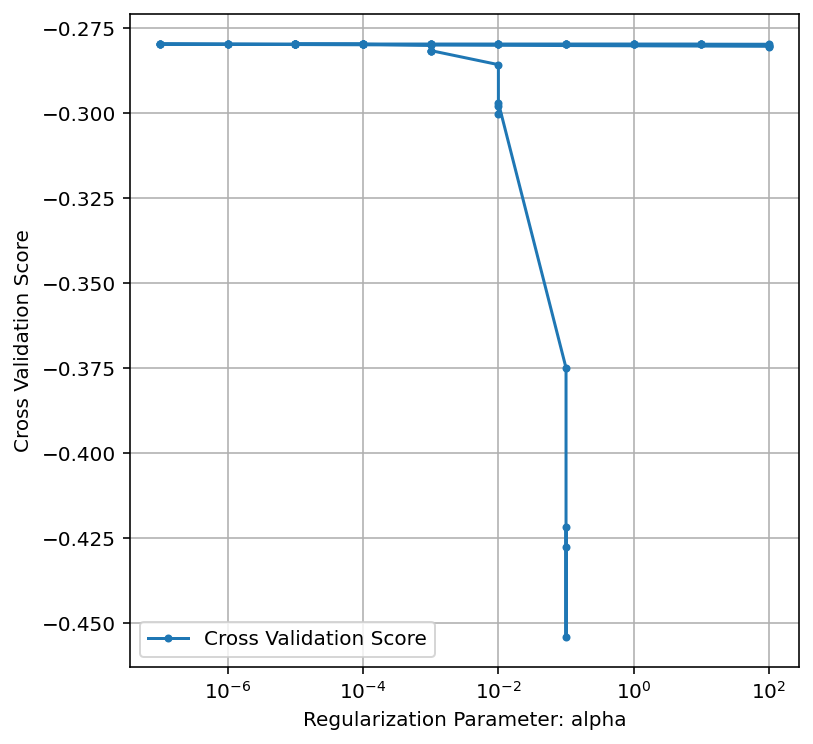

In [ ]:
# plot the results
plt.figure(figsize=(6,6))
plt.plot(alpha_df.param_model__alpha, alpha_df.mean_test_score ,label="Cross Validation Score",marker='.')
#add legend
plt.legend()
#add log scale
plt.xscale("log")
#add axes label
plt.xlabel('Regularization Parameter: alpha')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

In [ ]:
LinearRegression=Ridge()

linear_best=LinearRegression.fit(X_train, y_log_train)
y_pred=linear_best.predict(X_test)
y_train_pred=linear_best.predict(X_train)


# Inverse log transformation
y_train_rev=np.expm1(y_log_train)
y_train_pred_rev=np.expm1(y_train_pred)

y_test_rev=np.expm1(y_log_test)
y_pred_rev=np.expm1(y_pred)


# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train_rev,y_train_pred_rev),2)
test_mean=round(mean_absolute_error(y_test_rev, y_pred_rev),2)

# Define r2 
train_r=r2_score(y_train_rev,y_train_pred_rev)
test_r=r2_score(y_test_rev,y_pred_rev)

n_train=len(X_train)
p_train=len(X_train.columns)

n_test=len(X_test)
p_test=len(X_test.columns)

Adj_train_r2 = 1-(1-train_r)*(n_train-1)/(n_train-p_train) 
Adj_test_r2 = 1-(1-test_r)*(n_test-1)/(n_test-p_test) 


train_r2=round(Adj_train_r2 ,2)
test_r2=round(Adj_test_r2,2)




#print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')


-------------------
Train set Mean AE: 44.43
Test set Mean AE: 44.3
-------------------
Train set r2 score: 0.6
Test set r2 score: 0.6


In [ ]:
# Create an empty model result table
results_table1 = pd.DataFrame(index=['Model', 'R^2', 'MAE'])
results_table1

""
Model
R^2
MAE


In [ ]:
results_table1['Ridge_Regression'] = ['linear_optimized', 0.60,44.30]

In [ ]:
coefficients = linear_best.coef_

coefficients

array([[ 7.65711153e-02, -4.53659151e-02,  6.15732383e-03,
        -2.84529947e-02,  1.52548922e-01,  2.60199806e-02,
        -8.14426693e-02,  1.39003802e-01,  2.86438706e-01,
         3.32729585e-01,  3.30647759e-01,  3.52924025e-01,
         2.59317044e-01,  1.60807347e-01,  5.57414457e-02,
        -9.20775915e-02,  8.37342987e-02,  4.34104592e-02,
         3.21732294e-02,  1.24390241e-02,  1.58556163e-01,
         4.49403494e-02,  3.94356094e-02, -2.74791153e-02,
        -1.10788725e-02,  5.70184059e-02, -9.63229239e-02,
         8.64931143e-02,  2.70917333e-02, -8.21335208e-02,
         1.28116061e-01,  7.58354618e-02,  1.02619584e-01,
        -1.60387487e-02, -3.06581397e-03, -2.26598013e-02,
        -3.45288657e-02, -3.39050260e-02, -8.95517850e-02,
         9.93204384e-02,  4.63928624e-02, -5.06033866e-02,
         7.07871383e-02, -5.09263799e-03,  1.93275972e-02,
        -1.11457542e-02,  4.70301003e-02,  4.85469045e-02,
         5.42068520e-02, -7.89524087e-03, -1.08019513e-0

In [ ]:
X_train.columns

Index(['host_is_superhost', 'number_of_reviews_l30d', 'instant_bookable',
       'total_host_listing_more_than_1', 'bathroom_more_than_1',
       'host_work_email_verification', 'neigh_harlem_manhattan',
       'neigh_central_park_manhattan', 'neigh_midtown_south_manhattan',
       'neigh_midtown_west_manhattan', 'neigh_midtown_east_manhattan',
       'neigh_lower_manhattan', 'neigh_closer_brooklyn', 'neigh_closer_queens',
       'neigh_closer_bronx', 'amenities_kitchen', 'amenities_washer',
       'amenities_paid_parking', 'amenities_free_parking',
       'amenities_street_parking', 'amenities_gym', 'amenities_breakfast',
       'amenities_elevator', 'amenities_security', 'amenities_host_greets_you',
       'amenities_dedicated_workspace', 'name_studio apartment',
       'name_central park', 'name_time square', 'name_east village',
       'name_upper east side', 'name_park slope', 'name_west village',
       'name_prospect park', 'descr_empire state building',
       'descr_within wal

In [ ]:
coefficients_df=pd.DataFrame(data=coefficients, index=[X_train.columns]).reset_index()


ValueError: ignored

In [ ]:
coefficients_df.rename({'level_0':'feature_name',0:'coefficient'},axis=1, inplace=True)
coefficients_df.sort_values(by='coefficient',ascending=False).head(25)

These are the top features which impact the price in a positive way. We are glad to see our engineered features in the list. Some of them are `neigh_lower_manhattan`,	 `neigh_closer_brooklyn`, `amenities_gym` or `amenities_washer`. Based on the results, we can say that

Major Features which allow hosts to list their places at higher price:
1. Renting out an entire apt
2. Higher number of accommodates
3. Renting an place in lower Manhattan (under 14th street)
4. Higher available days within 30 days.


Other geogprahic features that hold advantages are renting a place from other Manhattan neighborhood except for Harlem or Brooklyn neighborhoods which are nearby Manhattan.

In terms of amenities, dedicated workspace, washer, gym, elevator or paid parking helps the hosts increase their prices by a small percentage.

Other features that influence the listing price in a positive way are offering more than 1 bathroom, higher location review score and being a superhost on the website.

Surprisingly hosts who never responds or respond less 25% of the received messages tend to list their properties at higher price. We believe that they might have not done a propery marketing research before listing their property and do allocate enough time on their Airbnb business. Their occupancy rate may be helpful to answer these questions.

In [ ]:
coefficients_df=pd.DataFrame(data=coefficients, index=[X_train.columns]).reset_index()
coefficients_df.rename({'level_0':'feature_name',0:'coefficient'},axis=1, inplace=True)
coefficients_df.sort_values(by='coefficient',ascending=True).head(20)

,feature_name,coefficient
58,minimum_nights,-0.093522
57,number_of_reviews,-0.029380
15,amenities_kitchen,-0.029072
50,neighbourhood_group_cleansed_Bronx,-0.021283
1,number_of_reviews_l30d,-0.021178
52,neighbourhood_group_cleansed_Queens,-0.020705
53,neighbourhood_group_cleansed_Staten Island,-0.015750
60,review_scores_value,-0.014843
3,total_host_listing_more_than_1,-0.014227
38,descr_full size bed,-0.013878


These are the top bottom features which impact the price negatively. We are glad to see our engineered features again in the list again despite their lower correlation with the price/target variable.

We need to emphasize that all features except for minimum required nights have less than 2% correlation value. 

1. Minimum Nights: As the minimum required nights a visitor has to book for increases, the price tends to be lower because these hosts aim to maximize their occupancy rate by giving up from their profit. 

- Surprisingly as number of reviews increase, the price tends to decrease based on the lasso model. The reason could be that the experienced hosts may tend to have higher number of reviews and aim to have higher occupancy rate by lowering their prices.

- We did not expect that a property having a kitchen as one of its amenities would be listed at lower price. 

- If a property is located in the neighborhoods of Bronx, Queens, and Staten Island nearby Manhattan, it tends to have a lower value. In other words, the apartments in these boroughs which are not close to Manhattan are more likely to be expensive. It may happen because the apartments are getting bigger as we mo away from Manhattan.


Let's plot the residual line which shows us if the prediction data is normally distributed and how the prediction values are variant.

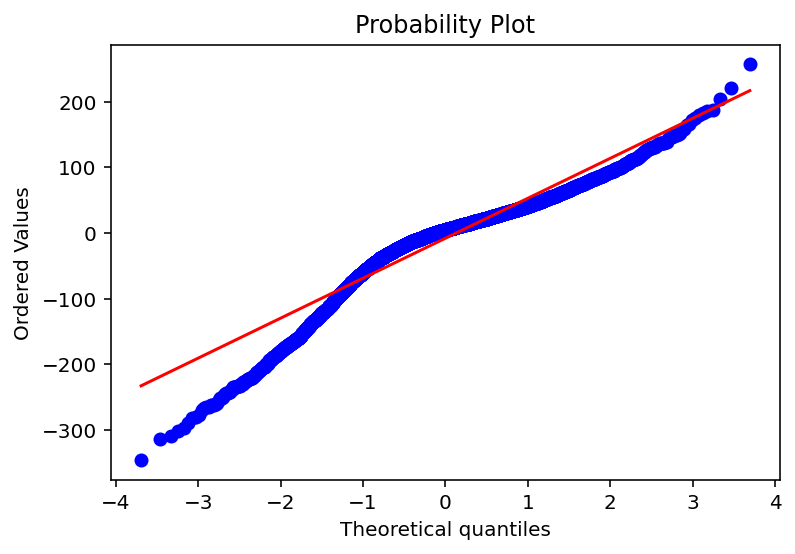

In [ ]:
stats.probplot((y_pred_rev.flatten()-y_test_rev.values.flatten()), dist='norm', plot=plt)
plt.title=('Residual Line Plot')
plt.show()

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":reg.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

NameError: ignored

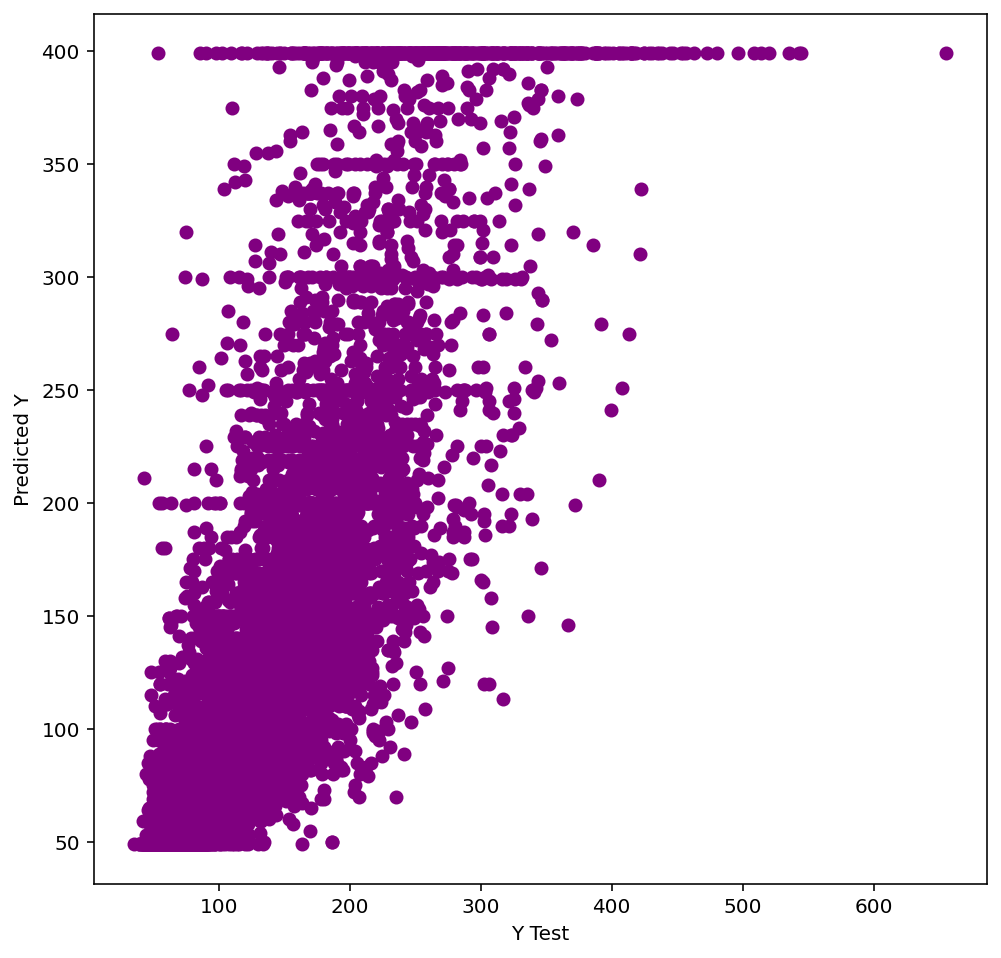

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(y_pred_rev.flatten(),y_test_rev.values.flatten(),c='purple')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

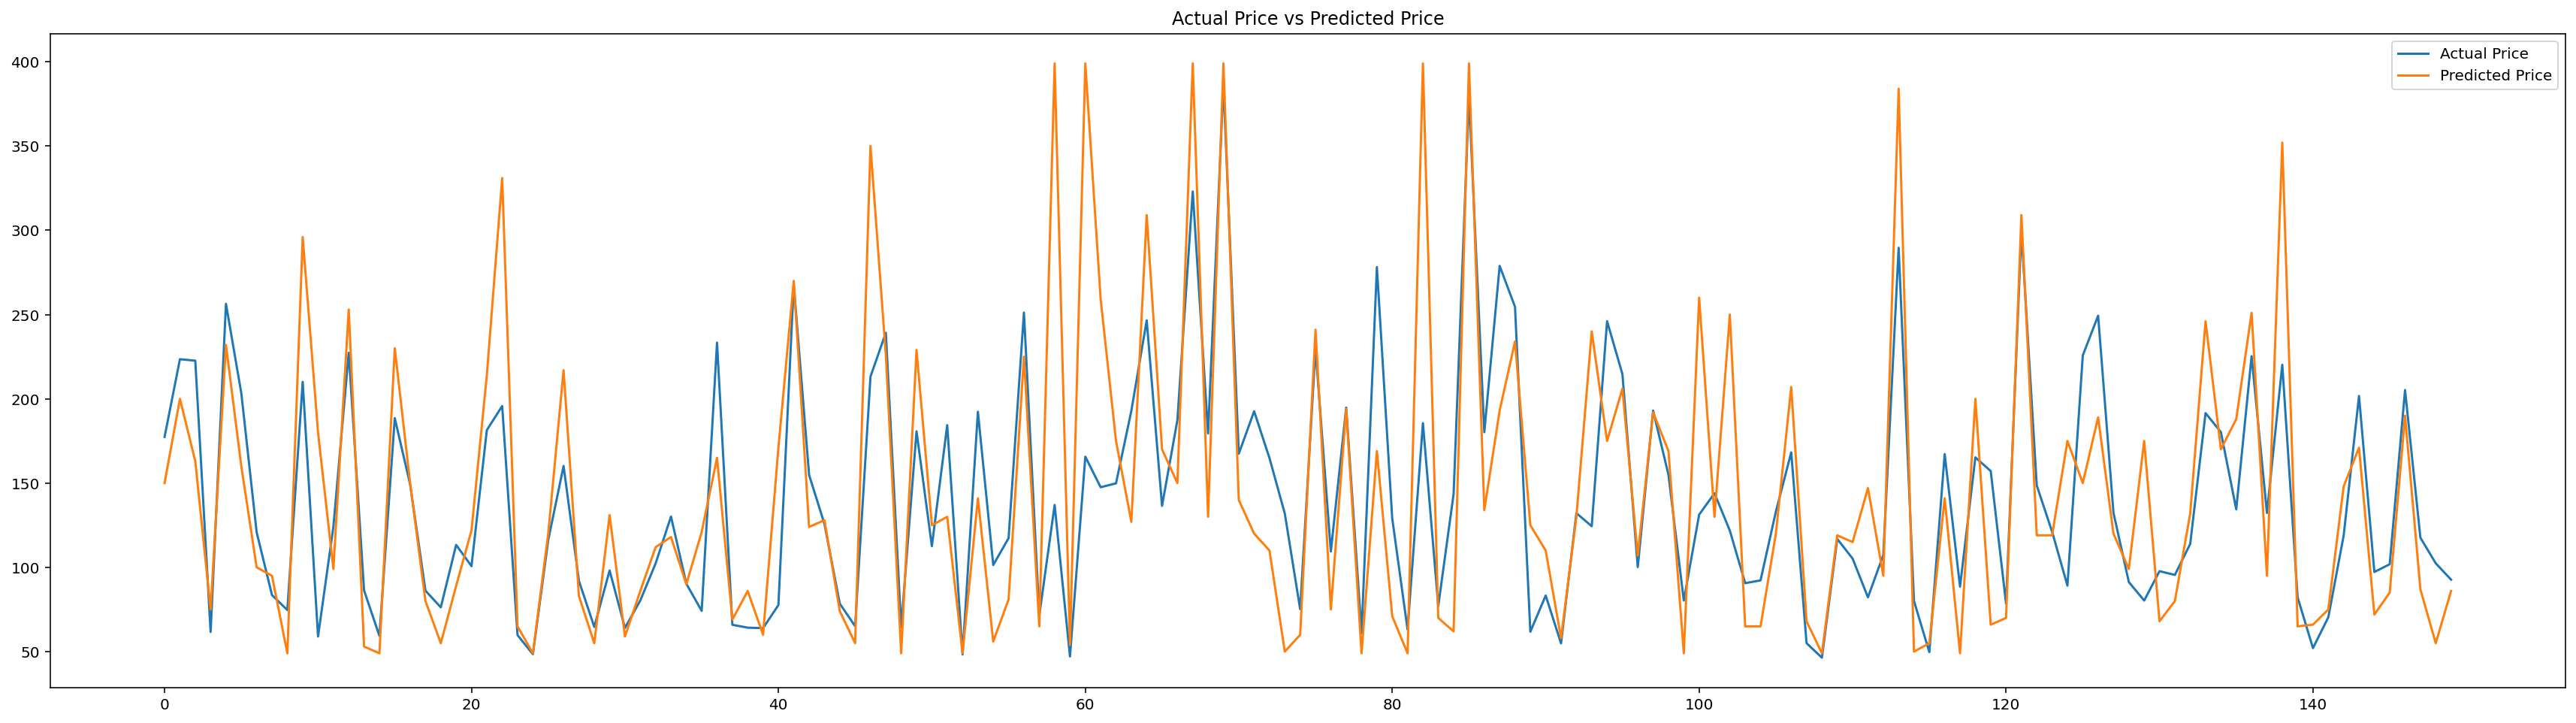

In [ ]:
#Flatten the y_pred array and y_test dataframe
test = pd.DataFrame({'Predicted value':y_pred_rev.flatten(), 'Actual value':y_test_rev.values.flatten()})
fig= plt.figure(figsize=(30,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:150])
plt.title('Actual Price vs Predicted Price')
plt.legend(['Actual Price','Predicted Price'])

In [ ]:
y_train_df=pd.DataFrame(y_train_pred_rev,columns=['predicted price'])
y_train_df

,predicted price
0,144.707675
1,75.874786
2,88.417851
3,161.691633
4,272.360910
...,...
25102,49.575951
25103,121.186838
25104,80.306905
25105,145.610501


In [ ]:
frames=[X_train, y_train_df]
train_df=pd.concat(frames,axis=1)

over_300_df=train_df[train_df['predicted price']>300]
over_300_df.describe()

,host_is_superhost,number_of_reviews_l30d,instant_bookable,total_host_listing_more_than_1,bathroom_more_than_1,host_work_email_verification,neigh_harlem_manhattan,neigh_central_park_manhattan,neigh_midtown_south_manhattan,neigh_midtown_west_manhattan,...,review_scores_location,availability_30,number_of_reviews,minimum_nights,maximum_nights,review_scores_value,host_since_months,listing_per_neighborhood,accommodates,predicted price
count,1169.00000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,...,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000
mean,0.24722,0.348161,0.431993,0.598802,0.562019,0.174508,0.016253,0.082977,0.090676,0.142857,...,0.546509,0.758390,-0.340060,-0.442927,0.059368,-0.163243,-0.190731,0.162059,1.261153,360.047901
std,0.43158,0.476591,0.495565,0.490351,0.496351,0.379708,0.126502,0.275965,0.287270,0.350077,...,0.667597,0.853367,1.109493,0.928046,0.897964,0.852485,1.080367,0.788263,0.568394,54.571118
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.203434,-0.888187,-1.604982,-1.313343,-1.867446,-2.439375,-2.122591,-2.119207,-0.411797,300.017723
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.291631,0.412025,-1.604982,-1.313343,-0.701759,-0.400104,-1.099306,-0.506257,0.906866,317.695599
50%,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.934946,1.075833,-0.383224,-0.780938,-0.015194,-0.364279,-0.089054,0.348859,1.304746,342.993338
75%,0.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.934946,1.432309,0.637046,0.912640,0.987534,0.245397,0.752633,0.810243,1.615107,389.358483
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.934946,1.571913,2.271482,1.396497,0.987534,1.307303,2.299043,1.546221,1.866061,640.300028


In [ ]:
xgb_predict_df = pd.DataFrame({'Actual Cap Hit':y_test_rev.values.flatten(),
                               'Predicted Cap Hit': y_pred_rev.flatten(),
                               'Upper Limit': (y_pred_rev.flatten())+mean_val_scores,
                               'Lower Limit': (y_pred_rev.flatten())-mean_val_scores,
                               'Amount Missed': y_pred_rev.flatten()-y_test_rev.values.flatten()})

NameError: ignored

**SVR:** We will try another regression model called SVR.

In [ ]:

# Define our model and normalization technique including parameters


estimators = [('normalise', StandardScaler()),('model', SVR())]

pipe = Pipeline(estimators)

params = [
           {'normalise': [StandardScaler(),MinMaxScaler(),RobustScaler(),None],
            'model': [SVR()],
            'model__kernel': ['linear', 'rbf','poly'],
            'model__C':[1.5,10],
            'model__gamma':[1e-7, 1e-4],
            'model__epsilon':[0.1,0.2,0.5,0.3]
            
           } 
    
]
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)  #should I use it?


# Determine the score type and set cross validation paramater 
clf = RandomizedSearchCV(estimator=pipe, cv=cv,n_iter=10, random_state=seed,
                   param_distributions=params,
                   scoring='neg_mean_absolute_error',verbose=10)

clf.fit(X_train, y_log_train.values.ravel())




Fitting 30 folds for each of 10 candidates, totalling 300 fits
[CV 1/30; 1/10] START model=SVR(), model__C=1.5, model__epsilon=0.2, model__gamma=0.0001, model__kernel=poly, normalise=MinMaxScaler()
[CV 1/30; 1/10] END model=SVR(), model__C=1.5, model__epsilon=0.2, model__gamma=0.0001, model__kernel=poly, normalise=MinMaxScaler();, score=-0.541 total time=  26.7s
[CV 2/30; 1/10] START model=SVR(), model__C=1.5, model__epsilon=0.2, model__gamma=0.0001, model__kernel=poly, normalise=MinMaxScaler()
[CV 2/30; 1/10] END model=SVR(), model__C=1.5, model__epsilon=0.2, model__gamma=0.0001, model__kernel=poly, normalise=MinMaxScaler();, score=-0.540 total time=  28.0s
[CV 3/30; 1/10] START model=SVR(), model__C=1.5, model__epsilon=0.2, model__gamma=0.0001, model__kernel=poly, normalise=MinMaxScaler()
[CV 3/30; 1/10] END model=SVR(), model__C=1.5, model__epsilon=0.2, model__gamma=0.0001, model__kernel=poly, normalise=MinMaxScaler();, score=-0.536 total time=  25.0s
[CV 4/30; 1/10] START model=SVR

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                             ('model', SVR())]),
                   param_distributions=[{'model': [SVR(C=10, epsilon=0.2,
                                                       gamma=0.0001)],
                                         'model__C': [1.5, 10],
                                         'model__epsilon': [0.1, 0.2, 0.5, 0.3],
                                         'model__gamma': [1e-07, 0.0001],
                                         'model__kernel': ['linear', 'rbf',
                                                           'poly'],
                                         'normalise': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       RobustScaler(), None]}],
                   random_state=42, scoring='

In [ ]:
#checking the best score and parameter
print("Best parameters:", clf.best_params_)
print("Lowest NMAE: ", (clf.best_score_))

Best parameters: {'normalise': StandardScaler(), 'model__kernel': 'rbf', 'model__gamma': 0.0001, 'model__epsilon': 0.2, 'model__C': 10, 'model': SVR(C=10, epsilon=0.2, gamma=0.0001)}
Lowest NMAE:  -0.2754248594685922


In [ ]:


y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

# Inverse the log transformation
y_train_rev=np.expm1(y_log_train)
y_train_pred_rev=np.expm1(y_train_pred)

y_test_rev=np.expm1(y_log_test)
y_pred_rev=np.expm1(y_pred)





# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train_rev,y_train_pred_rev),2)
test_mean=round(mean_absolute_error(y_test_rev, y_pred_rev),2)

# Define r2 
train_r=r2_score(y_train_rev,y_train_pred_rev)
test_r=r2_score(y_test_rev,y_pred_rev)

n_train=len(X_train)
p_train=len(X_train.columns)

n_test=len(X_test)
p_test=len(X_test.columns)

Adj_train_r2 = 1-(1-train_r)*(n_train-1)/(n_train-p_train) 
Adj_test_r2 = 1-(1-test_r)*(n_test-1)/(n_test-p_test) 


train_r2=round(Adj_train_r2 ,2)
test_r2=round(Adj_test_r2,2)




#print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')


-------------------
Train set Mean AE: 43.71
Test set Mean AE: 43.82
-------------------
Train set r2 score: 0.61
Test set r2 score: 0.59


In [ ]:
# Add the results to the results table
results_table1['SVM'] = ['SVM_optimized', 0.59, 43.82]

NameError: ignored

In [ ]:
results_table1

,Linear_Regression,Lasso__Regression,SVM
Model,linear_optimized,lasso_optimized,SVM_optimized
R^2,0.6,0.6,0.58
MAE,44.29,44.29,46.87


Finally, we can see that Ridge Regression is doing very similar to other Linear Regression models. Even though we have removed the outliers and transformed the skewed features, the Mean Absolute Error is still high. After capping the outliers in the price column, the mean price in Manhattan was 200 (US dollar). The listing price will be predicted as either 44 (US dollar) lower or higher than the actual price with 60% variance. 

### **Next Step:**

We will build and optimize the Random Forest and LightGBM Regression Models. The data will be fitted to both models.



---


Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 3 of 4